In [2]:
# Setup OpenAI's GPT-4o model for use with LangChain
from langchain_openai import ChatOpenAI
model = ChatOpenAI(
    model="gpt-4o")

In [4]:
# Setup text splitter to split documents into manageable chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

In [5]:
# Setup document loaders and vector store
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma

# Load text documents from a directory
loader = DirectoryLoader("/Users/Raj/Documents/AgenticAI-2.0/data2",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()

In [6]:
# Split the loaded documents into smaller chunks with RecursiveCharacterTextSplitter
new_docs=text_splitter.split_documents(documents=docs)

In [ ]:
# Validate the split document chunks
doc_string=[doc.page_content for doc in new_docs]
doc_string

In [ ]:
# Setup HuggingFace embeddings for document chunk embedding
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2")
    
# Embed the document chunks using HuggingFace embeddings
db=Chroma.from_documents(new_docs,embeddings)

/opt/miniconda3/envs/langenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Setup retriever to search through the embedded documents with 3 results
retriever=db.as_retriever(search_kwargs={"k": 3})
retriever.invoke("industrial growth of usa?")

[Document(metadata={'source': '/Users/Raj/Documents/AgenticAI-2.0/data2/usa.txt'}, page_content='The U.S. economy remains the engine of global growth, backed by unmatched innovation, financial dominance, and a strong institutional framework. Its $28 trillion GDP and influence over global'),
 Document(metadata={'source': '/Users/Raj/Documents/AgenticAI-2.0/data2/usa.txt'}, page_content='GDP Growth Trends and Dynamics'),
 Document(metadata={'source': '/Users/Raj/Documents/AgenticAI-2.0/data2/usa.txt'}, page_content='The U.S. maintains its GDP growth through strong innovation, entrepreneurship, and investment in R&D. With companies like Apple, Google, Amazon, Microsoft, and Tesla leading global markets, the U.S.')]

In [11]:
# Import libraries for validation, parsing, StateGraph, and message handling
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END

In [12]:
# Setup Parser Class for a structured output of topic selection
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [13]:
# Setup pydantic output parser to convert the model's output into the structured format
from langchain.output_parsers import PydanticOutputParser
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)
#parser.get_format_instructions()

In [86]:
# Define AgentState using TypedDict to hold the state of the agent
# using Total=False to allow for optional fields
class AgentState(TypedDict, total=False):
    query: str  # The user's query or question
    results: list[str]  # List of results generated by the agent
    next_step: str  # The next step or action to be taken by the agent
    validation: bool    # Flag to indicate if the results have been validated
    retries: int = 0  # retry count when retrying to get results

# Initialize the agent state with default values
agent_state: AgentState = {
    "query": "",
    "results": [],
    "next_step": "",
    "validation": False,
    "retries": 0
}

In [148]:
# define the node to assess the user query for next step
def assess_user_query(state:AgentState):
    
    question=state["query"]
    
    print("Question",question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [LLM CALL,RAG CALL,WEB CALL]. 
    Only respond with the category name and nothing else.
    If the query is related to USA, classify it as "RAG CALL".
    If the query needs answer from internet web search, classify it as "WEB CALL".
    If the query is not related to USA and does not need a web search, classify it as "LLM CALL".
    
    User query: {question}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    
    chain= prompt | model | parser
    
    response = chain.invoke({"question":question})
    
    print("Parsed response:", response)
    
    # Update the state with the next step based on the response
    state["next_step"] = response.Topic
    return state

In [88]:
# Pass user query to the assess_user_query function
state = {"query": ["What is the industrial growth of India?"]}
assess_user_query(state)

Question ['What is the industrial growth of India?']
Parsed response: Topic='LLM CALL' Reasoning='The query is about the industrial growth of India, which does not relate to the USA and does not require real-time or updated information from a web search.'


{'query': ['What is the industrial growth of India?'], 'next_step': 'LLM CALL'}

In [112]:
# Define router function to decide the next step
def router(state: AgentState):
    """
    Router function to decide which branch to take based on the last message.
    """
    print("-> in Router function")
    next_step = state["next_step"]
    #next_step = state.get("next_step", ["LLM CALL"])
    print("Next Step : ", next_step)
    if "RAG" in next_step.upper():
        return "RAG CALL"
    elif "WEB" in next_step.upper():
        return "WEB CALL"
    else:
        return "LLM CALL"

In [150]:
#RAG CALL
def rag_call(state: AgentState):
    """
    RAG call function to retrieve relevant documents from vector DB and generate a response.
    """
    print("-> in RAG call function")
    question = state["query"]
    print("Last message:", question)
    
    # Retrieve relevant documents
    retrieved_docs = retriever.invoke(question)
    
    # Generate a response using the retrieved documents
    rag_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant that provides information based on the provided documents."),
        ("human", "{question}"),
        ("human", "Here are some relevant documents: {documents}")
    ])
    
    rag_chain = rag_prompt | model | StrOutputParser()
    
    response = rag_chain.invoke({
        "question": question,
        "documents": "\n".join([doc.page_content for doc in retrieved_docs])
    })
    
    print(" Response from RAG chain: ", response)
    if "results" not in state:
        state["results"] = []
    state["results"].append(response)
    return state 

In [120]:
# LLM CALL
def llm_call(state: AgentState):
    """
    LLM call function to generate a response without using RAG.
    """
    print("-> in LLM call function")
    question = state["query"]
    print("Last message:", question)
    
    llm_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant that provides information based on the user's query."),
        ("human", "{question}")
    ])
    
    llm_chain = llm_prompt | model | StrOutputParser()
    
    response = llm_chain.invoke({"question": question})
    if "results" not in state:
        state["results"] = []
    state["results"].append(response)
    return state 

In [92]:
# Setup Tavily Search for web search capabilities and load environment variables
from langchain_community.tools.tavily_search import TavilySearchResults
import os
from dotenv import load_dotenv
load_dotenv() 

tavily_search = TavilySearchResults(
    api_key=os.getenv("TAVILY_API_KEY"),
    top_k_results=5,
    doc_content_chars_max=500
)


In [93]:
# Define function to extract web search result contents from Tavily
def format_tavily_results(tavily_results: list) -> str:
    return "\n\n".join(result["content"] for result in tavily_results if "content" in result)


In [142]:
# WEB CALL
def web_call(state: AgentState):
    """
    WEB call function to generate a response from the internet.
    """
    print("-> in WEB call function")
    question = state["query"]
    print("Last message:", question)
    
    #get web search results using Tavily
    tavily_response = tavily_search.run(question)
    # Format the Tavily search results to extract content
    formatted_web_content = format_tavily_results(tavily_response)

    # If no content is found, provide a default message as response
    # when content is present, pass it to LLM for generating a summarized response
    if not formatted_web_content:
        response = "No relevant information found on the web."
    else:
        web_prompt = ChatPromptTemplate.from_messages([
            ("system", "You are a helpful assistant that summarizes information for the user"),
            ("human", "{question}"),
            ("human", "Here are some web search results for you to summarize: {formatted_web_content}")])
    
        web_chain = web_prompt | model | StrOutputParser()
    # Generate a response using the web search results
        response = web_chain.invoke({
            "question": question,
            "formatted_web_content": formatted_web_content
        })
    if "results" not in state:
        state["results"] = []
    state["results"].append(response)
    return state 

In [95]:
# Define validate function to decide & set if the response is valid or not
def validate_result(state: AgentState):
    """
    Validate function to check if the last response is valid.
    """
    print("-> in Validate function")
    last_message = state["results"][-1]
    
    # Simple validation logic: if the response is not empty, consider it valid

    if len(last_message)>0:
        state["validation"] = True
        print("Response is valid.")
    else:
        state["validation"] = False
        state["retries"] += 1
        print("Response is invalid.")
    
    return state

In [156]:
#define validate router function to decide the next step based on validation
def validate_router(state: AgentState):
    """
    Validate router function to decide the next step based on validation.
    """
    print("-> in Validate Router function")
    print(f"Validation={state['validation']} | Retries={state.get('retries', 0)}")
    # If validation is True or retries are more than 3, go to END
    # Otherwise, retry
    if state["validation"] or state["retries"] >= 3:
        print("Validation passed or max retries reached.")
        state["next_step"] = "END"
        return "END"
    else:
        print("Validation failed, retrying...")
        state["next_step"] = "RETRY"
        return "RETRY"

In [151]:
from langgraph.graph import StateGraph, END
#workflow defined with all nodes and edges at once. Conditional edges defined separately
workflow = StateGraph(AgentState) \
    .add_node("assess_user_query", assess_user_query) \
    .add_node("RAG CALL", rag_call) \
    .add_node("LLM CALL", llm_call) \
    .add_node("WEB CALL", web_call) \
    .add_node("validate_result", validate_result) \
    .set_entry_point("assess_user_query") \
    .add_edge("RAG CALL", "validate_result") \
    .add_edge("WEB CALL", "validate_result") \
    .add_edge("LLM CALL", "validate_result") 

# below conditional edge diverts the flow based on output from router function
workflow.add_conditional_edges(
    "assess_user_query", router,{
        "RAG CALL": "RAG CALL",
        "LLM CALL": "LLM CALL",
        "WEB CALL": "WEB CALL"
    }
)
workflow.add_conditional_edges(
    "validate_result", validate_router,{
        "RETRY": "assess_user_query",
        "END": END    
    }
)
#As an alternative, you can use the following syntax to define conditional edges right when workflow is created
#.add_edge("decide_usa_or_not", "RAG CALL", lambda state: state["messages"][0] == "USA") \
#.add_edge("decide_usa_or_not", "LLM CALL", lambda state: state["messages"][0] != "USA") \

In [157]:
app = workflow.compile()

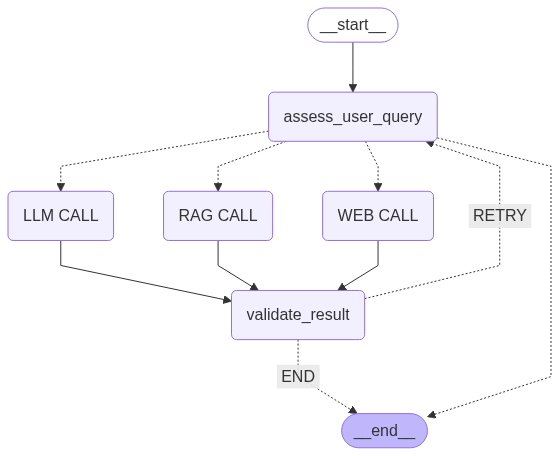

In [158]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# Learned that ChatOpenAI does not accept raw strings and GooglechatAI model implicity converts and a bit forgiving
# as best practice, we should use Humanmessage in the input so model get it in the way that it expects and portable across modesl
#from langchain_core.messages import HumanMessage
#state = {"messages": [HumanMessage(content="What is the industrial growth of USA?")]}

In [161]:
state = {"query": "What is the industrial growth of USA?",
    "results": [],
    "next_step": "",
    "validation": False,
    "retries": 0}

app.invoke(state)

Question What is the industrial growth of USA?
Parsed response: Topic='RAG CALL' Reasoning='The query is related to USA industrial growth.'
-> in Router function
Next Step :  RAG CALL
-> in RAG call function
Last message: What is the industrial growth of USA?
 Response from RAG chain:  The industrial growth of the United States is supported by several key factors: strong innovation, robust entrepreneurship, and significant investment in research and development (R&D). The U.S. economy, with its $28 trillion GDP, continues to be a major driver of global economic growth. Leading U.S. companies such as Apple, Google, Amazon, Microsoft, and Tesla are pivotal in maintaining this growth trajectory, holding significant influence in global markets.

The institutional framework in the U.S. also plays a crucial role in supporting industrial growth, providing a stable and conducive environment for businesses to thrive and innovate. Overall, these elements contribute to the sustained industrial gr

{'query': 'What is the industrial growth of USA?',
 'results': ['The industrial growth of the United States is supported by several key factors: strong innovation, robust entrepreneurship, and significant investment in research and development (R&D). The U.S. economy, with its $28 trillion GDP, continues to be a major driver of global economic growth. Leading U.S. companies such as Apple, Google, Amazon, Microsoft, and Tesla are pivotal in maintaining this growth trajectory, holding significant influence in global markets.\n\nThe institutional framework in the U.S. also plays a crucial role in supporting industrial growth, providing a stable and conducive environment for businesses to thrive and innovate. Overall, these elements contribute to the sustained industrial growth in the United States.'],
 'next_step': 'RAG CALL',
 'validation': True,
 'retries': 0}

In [162]:
state = {"query": "What is the industrial growth of India?",
    "results": [],
    "next_step": "",
    "validation": False,
    "retries": 0}

app.invoke(state)

Question What is the industrial growth of India?
Parsed response: Topic='LLM CALL' Reasoning='The query is about the industrial growth of India, which is not related to the USA and does not require a web search for the latest information.'
-> in Router function
Next Step :  LLM CALL
-> in LLM call function
Last message: What is the industrial growth of India?
-> in Validate function
Response is valid.
-> in Validate Router function
Validation=True | Retries=0
Validation passed or max retries reached.


{'query': 'What is the industrial growth of India?',
 'results': ['Industrial growth in India has been a key component of the country\'s economic development. Over the past few decades, India has experienced varying rates of industrial growth, influenced by both internal policies and external factors. Here are some key points regarding recent trends and the outlook for industrial growth in India:\n\n1. **Historical Growth**: Post-independence, India adopted a mixed-economy model with a significant emphasis on state-led industrial development. This changed in the 1990s when liberalization policies were implemented, leading to increased private sector participation and foreign investment in the industrial sector.\n\n2. **Current Trends**: In recent years, industrial growth has been driven by sectors such as manufacturing, construction, mining, and utilities. The government has implemented initiatives like "Make in India" to encourage domestic and foreign companies to manufacture in India

In [163]:
state = {"query": "What is the latest news about India?",
    "results": [],
    "next_step": "",
    "validation": False,
    "retries": 0}

app.invoke(state)

Question What is the latest news about India?
Parsed response: Topic='WEB CALL' Reasoning='The query requests the latest news about India, which requires current information from a web search.'
-> in Router function
Next Step :  WEB CALL
-> in WEB call function
Last message: What is the latest news about India?
-> in Validate function
Response is valid.
-> in Validate Router function
Validation=True | Retries=0
Validation passed or max retries reached.


{'query': 'What is the latest news about India?',
 'results': ['Here\'s a summary of the latest news about India:\n\n1. **Air India Plane Crash**: An Air India plane, flight 171 bound for London, crashed after takeoff from Ahmedabad. This tragic accident resulted in the deaths of at least 265 people, including those on board and on the ground. Rescue operations are ongoing at the crash site. The Tata Group, which owns Air India, has mobilized resources quickly to address the situation and assess the implications for the airline’s safety reputation.\n\n2. **Political Developments**: The Aam Aadmi Party (AAP) government has been accused of acting as a "commission agent" for real estate developers, highlighting ongoing political tensions and critiques from opposition figures.\n\n3. **Punjab\'s Technological Initiatives**: The state of Punjab has launched "Easy Jamabandi", a program aimed at streamlining land record management, which is expected to benefit the public and save governmental 